In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info
import os
import gc # garbage collection
import random
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16602765337550159918
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13436154390335948252
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [5]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers



In [6]:
folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)

# All date to int
df['date'] = df['date'].str.replace('c.', '').astype('int', errors='ignore')

print(df.head())


         artist  date                  genre  pixelsx  pixelsy  size_bytes  \
0  Paul Gauguin  1903         genre painting   1916.0   1688.0    363138.0   
1  Paul Gauguin  1893               portrait   2048.0   1348.0    293452.0   
2  Paul Gauguin  1892  mythological painting   1800.0   1082.0   1638911.0   
3  Paul Gauguin  1903         genre painting   1600.0   1067.0    307130.0   
4  Paul Gauguin  1892               portrait   1096.0   1476.0    467406.0   

    source               style                  title    artist_group  \
0  wikiart  Post-Impressionism         The Invocation  train_and_test   
1  wikiart         Cloisonnism                  Alone  train_and_test   
2  wikiart         Cloisonnism          The Royal End  train_and_test   
3  wikiart  Post-Impressionism  Women and white horse  train_and_test   
4  wikiart  Post-Impressionism            Two sisters  train_and_test   

   in_train new_filename  
0     False    35323.jpg  
1     False    73683.jpg  
2      True

# Create the TEST and TRAIN sets

In [7]:
# Function to read filenames from a folder and return a list of filenames
def get_filenames_from_folder(folder_path):
    filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return filenames

# Check if the TRAIN and TEST folders exist
if os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')):
    print("TRAIN and TEST folders exist. Reading image filenames...")

    # Get filenames from the TRAIN and TEST folders
    train_filenames = get_filenames_from_folder(os.path.join(folder, 'TRAIN'))
    test_filenames = get_filenames_from_folder(os.path.join(folder, 'TEST'))

    # Filter the df DataFrame to get the train and test DataFrames
    train_dataframe = df[df['new_filename'].isin(train_filenames)][['artist','date', 'new_filename']]
    test_dataframe = df[df['new_filename'].isin(test_filenames)][['artist','date', 'new_filename']]

    print("Train DataFrame:", train_dataframe.shape)
    print("Test DataFrame:", test_dataframe.shape)
else:
    print("TRAIN and TEST folders do not exist. Please create the folders and try again.")

TRAIN and TEST folders exist. Reading image filenames...
Train DataFrame: (400, 3)
Test DataFrame: (100, 3)


In [8]:
train_dataframe.head()

,artist,date,new_filename
0,Paul Gauguin,1903,35323.jpg
2,Paul Gauguin,1892,101871.jpg
3,Paul Gauguin,1903,76989.jpg
4,Paul Gauguin,1892,89439.jpg
5,Paul Gauguin,1885,64788.jpg


In [9]:
import numpy as np
from PIL import Image
import os

def get_meanstd(df, image_dir):
    means = []
    stds = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['new_filename'])
        img = np.array(Image.open(img_path)) / 255.0
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))

    meanR = np.mean([m[0] for m in means])
    meanG = np.mean([m[1] for m in means])
    meanB = np.mean([m[2] for m in means])

    stdR = np.mean([s[0] for s in stds])
    stdG = np.mean([s[1] for s in stds])
    stdB = np.mean([s[2] for s in stds])

    return [meanR, meanG, meanB], [stdR, stdG, stdB]


means, stds = get_meanstd(train_dataframe, folder+"/TRAIN")
print(f'Mean Values: {means}')
print(f'STD Values: {stds}')

Mean Values: [0.4902860351171657, 0.4327027123349515, 0.3679902021355657]
STD Values: [0.22134062718873712, 0.20430693703606892, 0.18851782142531143]


In [10]:
import itertools

def load_image(image_path,  means=None, stds=None):
    image = Image.open(image_path)
    image = np.array(image) / 255.0  # Normalize

    # Normalize using means and stds
    if means is not None and stds is not None:
        image = (image - means) / stds

    return image

def create_pairs_by_artist(df, image_dir, means, stds, mode):
    pairs = []
    labels = []
    artists = df['artist'].unique()

    for artist in artists:
        if mode == "TRAIN":
          artist_df = df[df['artist'] == artist].head(20)
        else:
          artist_df = df[df['artist'] == artist].head(9)
        artist_images = [os.path.join(image_dir, filename) for filename in artist_df['new_filename']]
        artist_pairs = list(itertools.combinations(artist_images, 2))

        for pair in artist_pairs:
            date_img1 = artist_df[artist_df['new_filename'] == pair[0].split("/")[-1]]['date'].tolist()[0]
            date_img2 = artist_df[artist_df['new_filename'] == pair[1].split("/")[-1]]['date'].tolist()[0]
            img1 = load_image(pair[0], means=means, stds=stds) # Load normalizing
            img2 = load_image(pair[1], means=means, stds=stds) # Load normalizing

            pairs.append([img1, img2])
            label = 1 if date_img1 > date_img2 else 0
            labels.append(label)

    return np.array(pairs), np.array(labels)
# Create training and test pairs
train_pairs, train_labels = create_pairs_by_artist(train_dataframe, folder+"/TRAIN", means, stds, mode = "TRAIN")
test_pairs, test_labels = create_pairs_by_artist(test_dataframe, folder+"/TEST", means, stds, mode = "TEST")


In [11]:
print("Number of pairs in TRAIN:", len(train_pairs))
print("Number of pairs in TEST:", len(test_pairs))

Number of pairs in TRAIN: 950
Number of pairs in TEST: 180


In [12]:
from torchvision import transforms

train_dataframe = train_dataframe.drop(columns=['artist'])
test_dataframe = test_dataframe.drop(columns=['artist'])
# Data Transformation

# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Standard transformations for test set
test0_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Update the transform functions for train_ds & test_all
train_dataframe.transform = train_transformer
test_dataframe.transform = test0_transformer

In [13]:
# Plotting the training and validation curves for loss and accuracy
def plot_out(loss_hist, metric_hist, epochs=None):
    # Create the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Loss history plot
    axs[0].plot(range(1, epochs+1), loss_hist["train"], label="Train loss")
    axs[0].plot(range(1, epochs+1), loss_hist["val"], label="Validation loss")
    axs[0].set_title('Loss History')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Metric history plot
    axs[1].plot(range(1, epochs+1), metric_hist["train"], label="Train accuracy")
    axs[1].plot(range(1, epochs+1), metric_hist["val"], label="Validation accuracy")
    axs[1].set_title('Accuracy History')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

# Vgg16

In [ ]:
input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu')(concatenated)
    dense = layers.Dense(256, activation='relu')(dense)
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    # Create the optimizer with your desired learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, epochs=50, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_2[0][0]',             
                                                          8          'input_3[0][0]']             
                                                                                                  
 flatten (Flatten)           

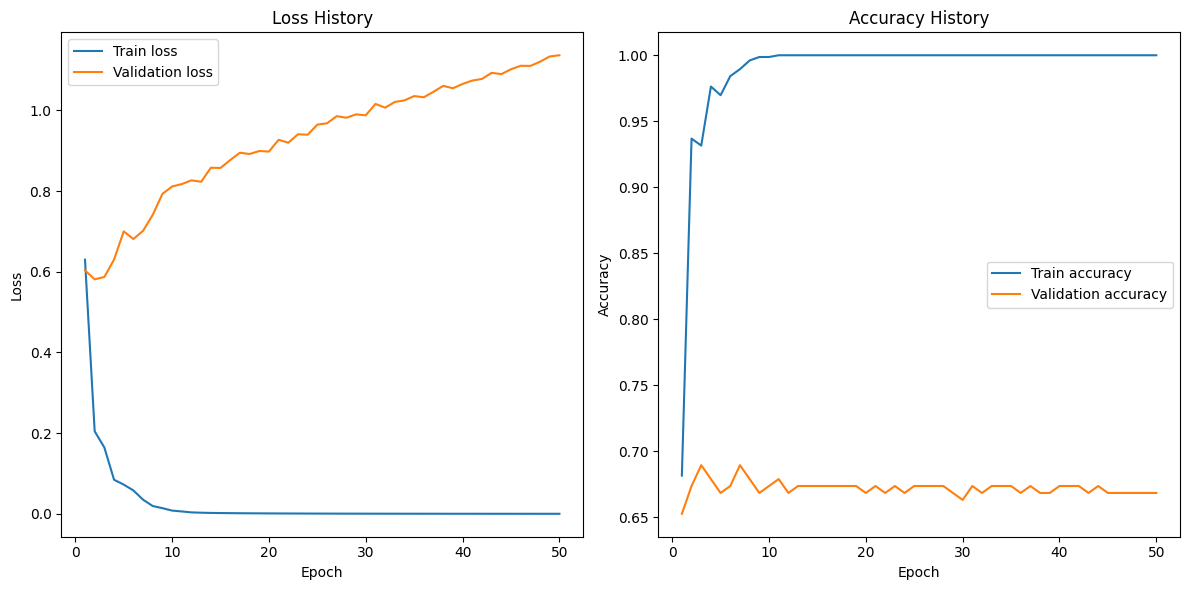

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))


In [ ]:
# Free up memory
del model
del history

# Avoid Overfitting Vgg16


## Unfreezing the last 2 layers and applying L2 regularization and dropout.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-2:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    # Agregar regularización L2 y dropout
    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.5)(dense)
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.5)(dense)
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, epochs=50, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_5[0][0]',             
                                                          8          'input_6[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']         

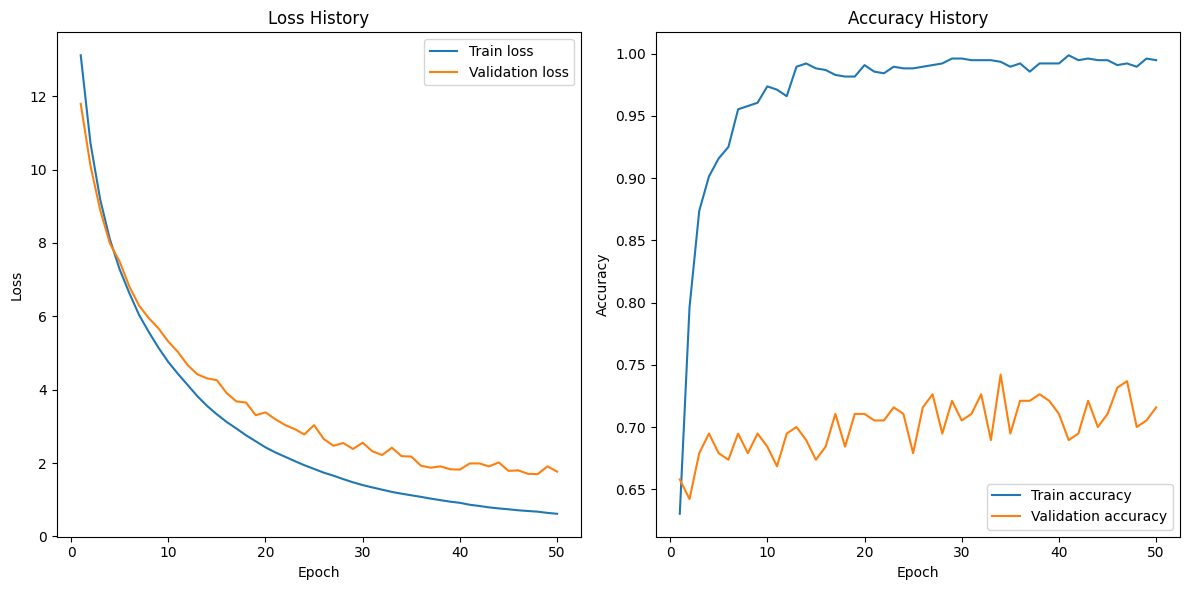

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## Unfreezing the last layer and applying L2 regularization and dropout.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-1:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    # Añadir Batch Normalization y Dropout
    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.5)(dense)
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.5)(dense)
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

# Early stopping and ReduceLROnPlateau callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_8[0][0]',             
                                                          8          'input_9[0][0]']             
                                                                                                  
 flatten_4 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']         

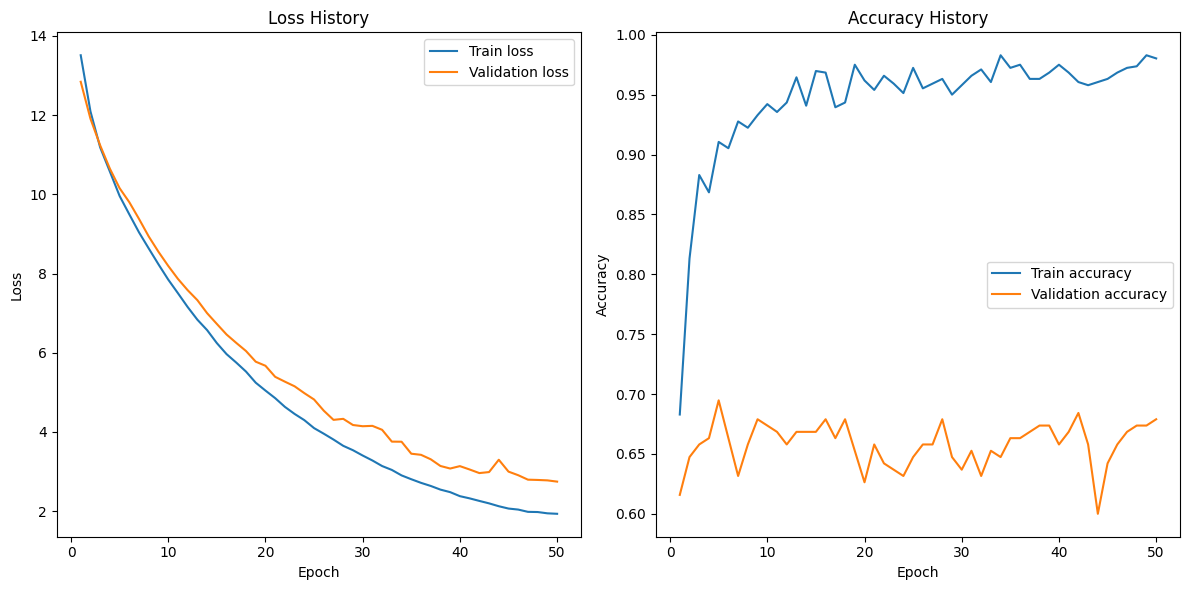

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## Unfreezing the last 2 layers and applying L2 regularization, earlystopping and dropout.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-2:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_2[0][0]',             
                                                          8          'input_3[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 25088)                0         ['vgg16[0][0]']           

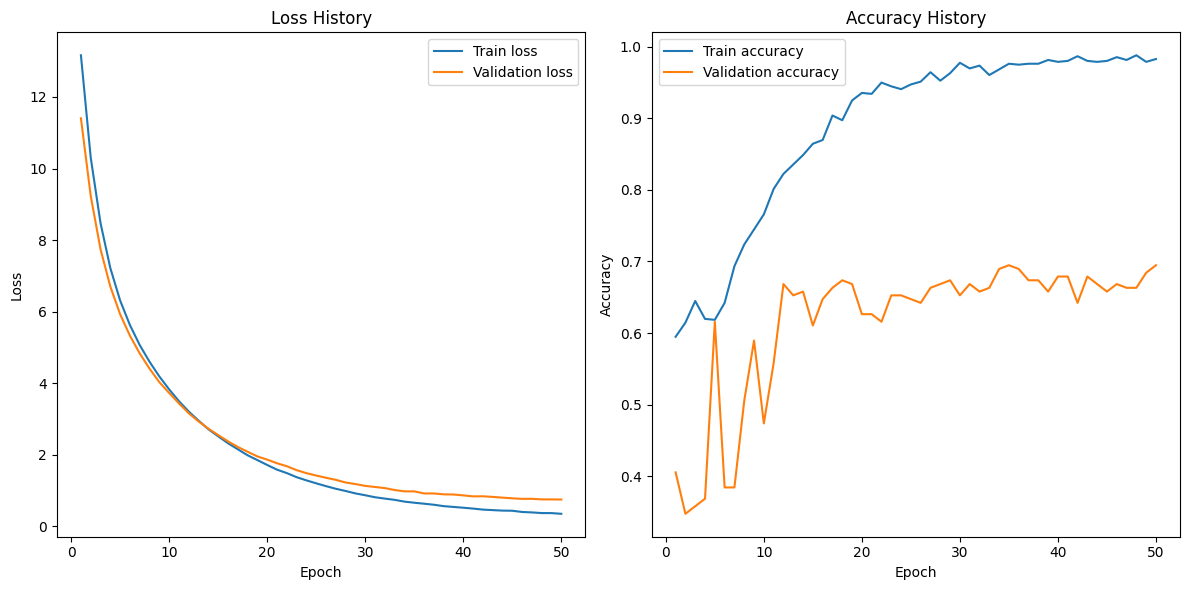

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## Unfreezing more layers (last 4)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-4:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_11[0][0]',            
                                                          8          'input_12[0][0]']            
                                                                                                  
 flatten_6 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']         

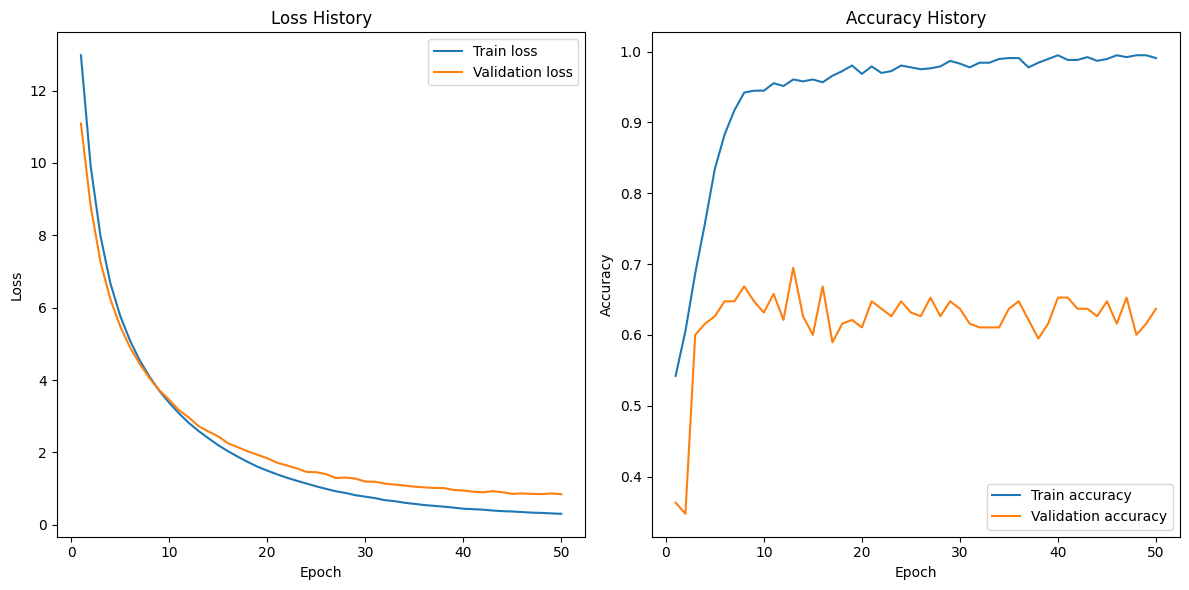

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## Unfreezing more layers (last 6)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-6:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_17[0][0]',            
                                                          8          'input_18[0][0]']            
                                                                                                  
 flatten_6 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']         

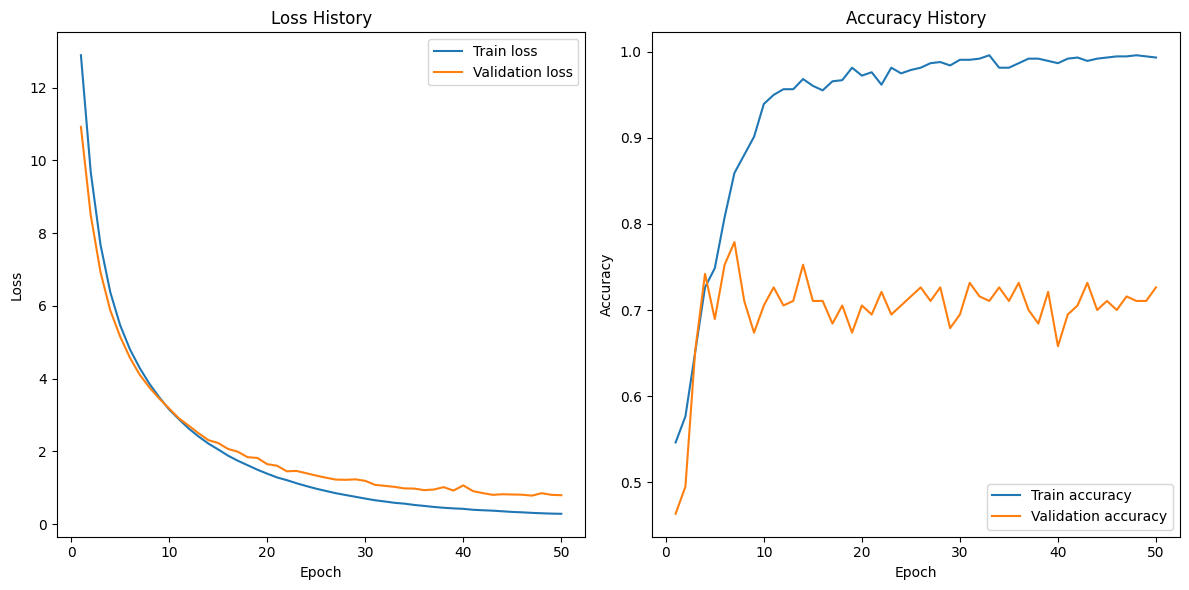

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

# THE BEST IS: Unfreezing more layers (last 4) + regularitzation l2 + dropout

### Now, let's try this but using ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-4:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.GlobalAveragePooling2D()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ensure train_pairs and train_labels are defined before using them
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_5[0][0]',             
                                                          2          'input_6[0][0]']             
                                                                                                  
 global_average_pooling2d (  (None, 2048)                 0         ['resnet50[0][0]']      

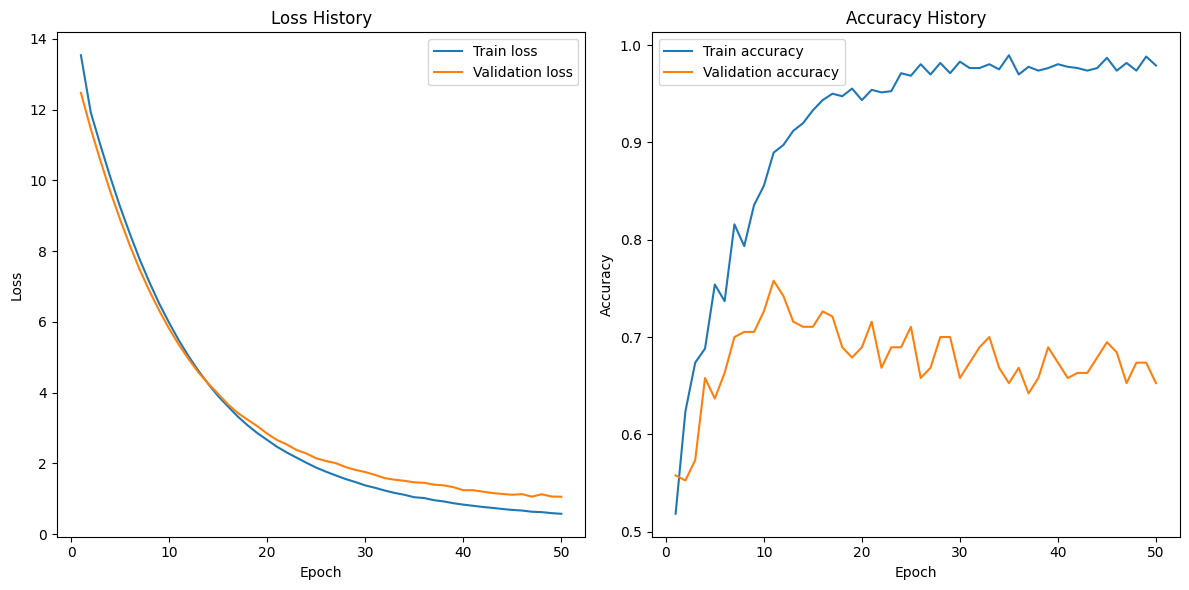

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## Let's try the las one but only unfreezing the last 2 layers


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-2:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.GlobalAveragePooling2D()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ensure train_pairs and train_labels are defined before using them
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_11[0][0]',            
                                                          2          'input_12[0][0]']            
                                                                                                  
 global_average_pooling2d_4  (None, 2048)                 0         ['resnet50[0][0]']      

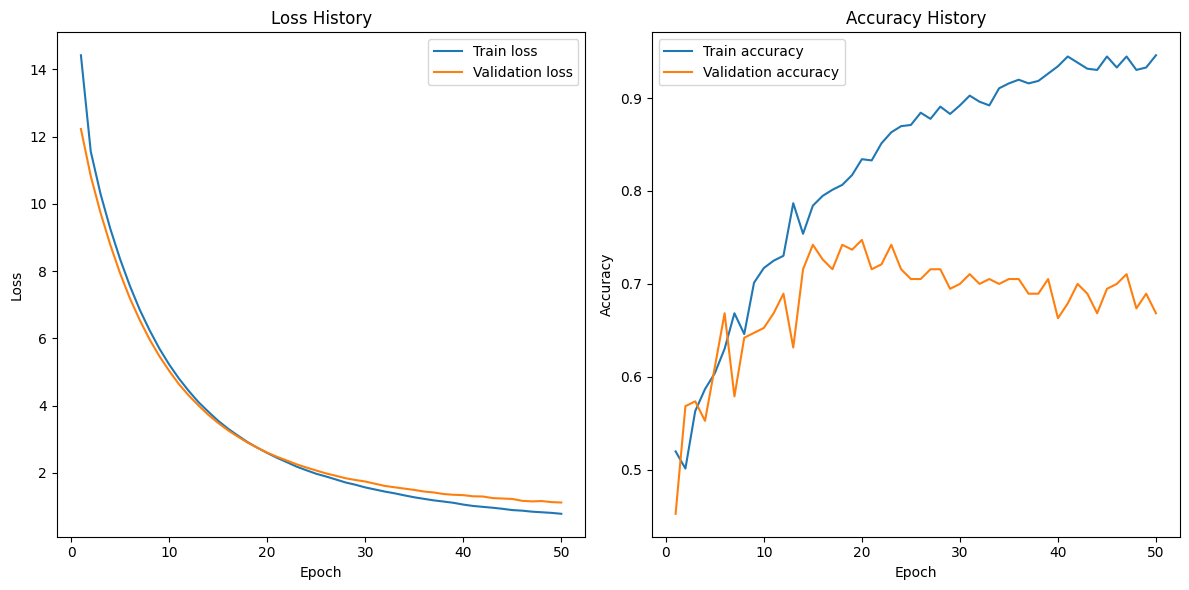

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## Now undefreezing only the last

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-1:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.GlobalAveragePooling2D()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ensure train_pairs and train_labels are defined before using them
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_2[0][0]',             
                                                          2          'input_3[0][0]']             
                                                                                                  
 global_average_pooling2d (  

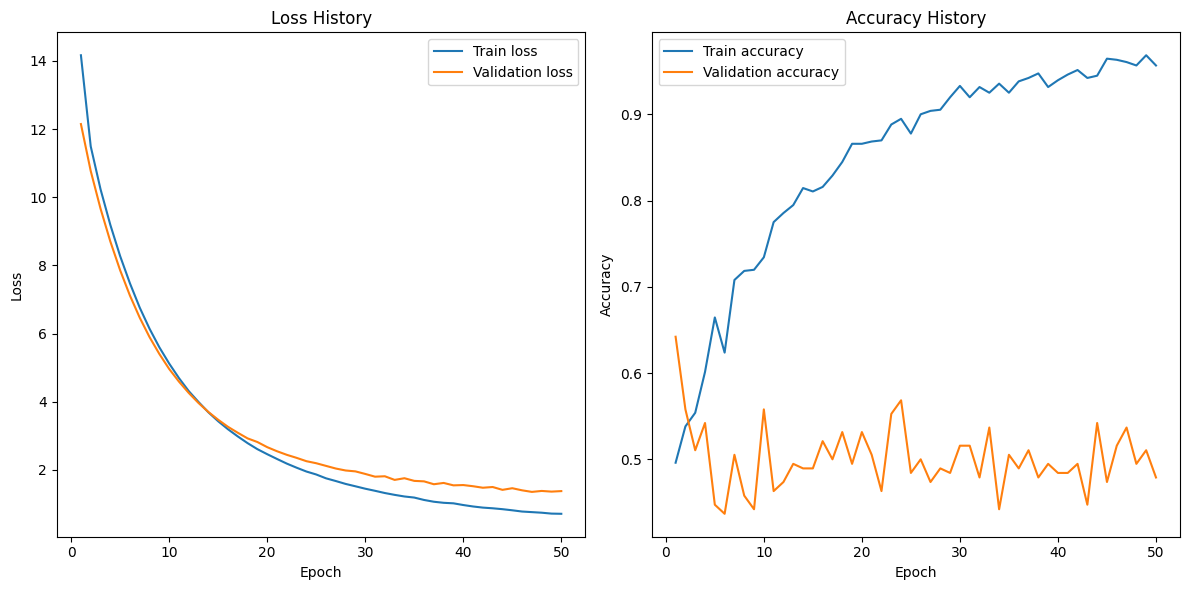

In [15]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

## The best model of Vgg with early stopping of val_accuracy

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-4:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_8[0][0]',             
                                                          8          'input_9[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 25088)                0         ['vgg16[0][0]']         

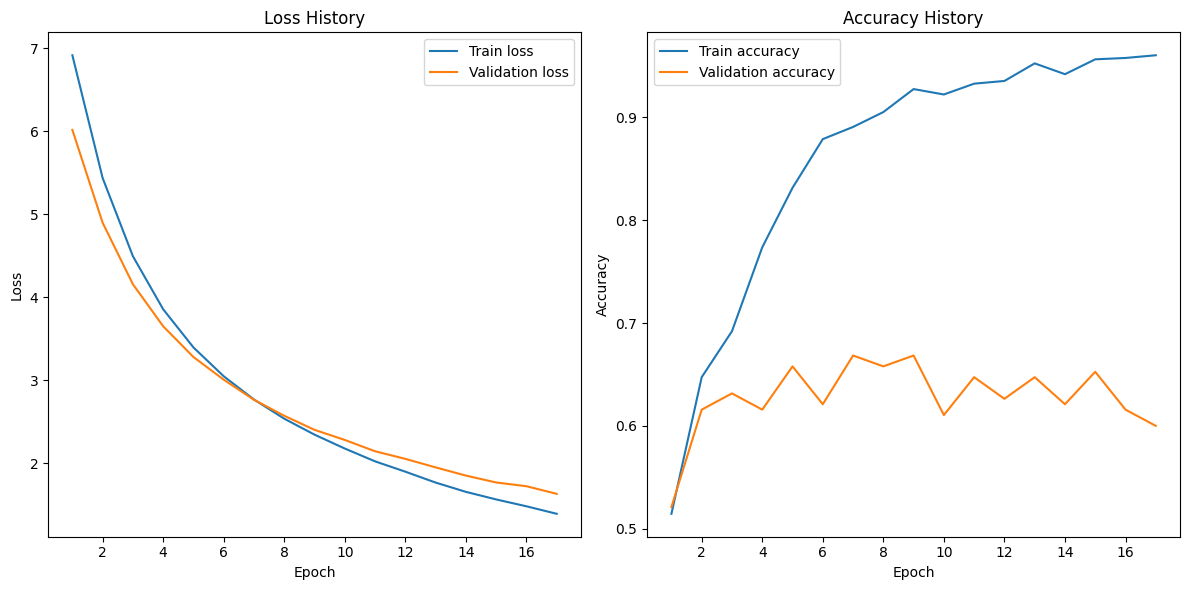

In [19]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))